In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path ke direktori dataset
train_dir = '/content/drive/MyDrive/SkinDisease(9010)/train'
test_dir = '/content/drive/MyDrive/SkinDisease(9010)/test'

In [ ]:
# Image size
img_size = (224, 224)

# Training with more augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
# Train and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

Found 720 images belonging to 10 classes.
Found 180 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [ ]:
# Membangun model DenseNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the base model (more layers)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# Compile the model
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[LearningRateScheduler(lr_scheduler), early_stopping]
)

Epoch 1/50
23/23 [==============================] - 296s 12s/step - loss: 2.7090 - accuracy: 0.1222 - val_loss: 2.1981 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 2/50
23/23 [==============================] - 19s 819ms/step - loss: 2.2839 - accuracy: 0.1972 - val_loss: 2.0804 - val_accuracy: 0.2333 - lr: 1.0000e-04
Epoch 3/50
23/23 [==============================] - 20s 886ms/step - loss: 2.0479 - accuracy: 0.2903 - val_loss: 1.8800 - val_accuracy: 0.2833 - lr: 1.0000e-04
Epoch 4/50
23/23 [==============================] - 18s 801ms/step - loss: 1.8727 - accuracy: 0.3014 - val_loss: 1.8679 - val_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 5/50
23/23 [==============================] - 19s 814ms/step - loss: 1.8036 - accuracy: 0.3208 - val_loss: 1.7993 - val_accuracy: 0.3278 - lr: 1.0000e-04
Epoch 6/50
23/23 [==============================] - 18s 784ms/step - loss: 1.7568 - accuracy: 0.3333 - val_loss: 1.7737 - val_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 7/50
23/23 [=======================

In [ ]:
# Evaluation
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

4/4 [==============================] - 22s 7s/step - loss: 1.2590 - accuracy: 0.5200
Test Accuracy: 52.00%


In [ ]:
# Classification Report
# Predict classes for test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# True classes for test set
true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Generate classification report
report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

4/4 [==============================] - 3s 201ms/step
                      precision    recall  f1-score   support

          Basal-Cell       0.00      0.00      0.00        10
    Benign-Keratosis       0.00      0.00      0.00        10
   Dermatitis-Atopik       0.11      0.20      0.14        10
               Eksim       0.00      0.00      0.00        10
    Melanocytic-Nevi       0.17      0.10      0.12        10
            Melanoma       0.14      0.20      0.17        10
           Psoriasis       0.00      0.00      0.00        10
Seborrheic-Keratosis       0.00      0.00      0.00        10
      Tinea-Ringworm       0.00      0.00      0.00        10
     Warts Molluscum       0.15      0.20      0.17        10

            accuracy                           0.07       100
           macro avg       0.06      0.07      0.06       100
        weighted avg       0.06      0.07      0.06       100



4/4 [==============================] - 2s 103ms/step


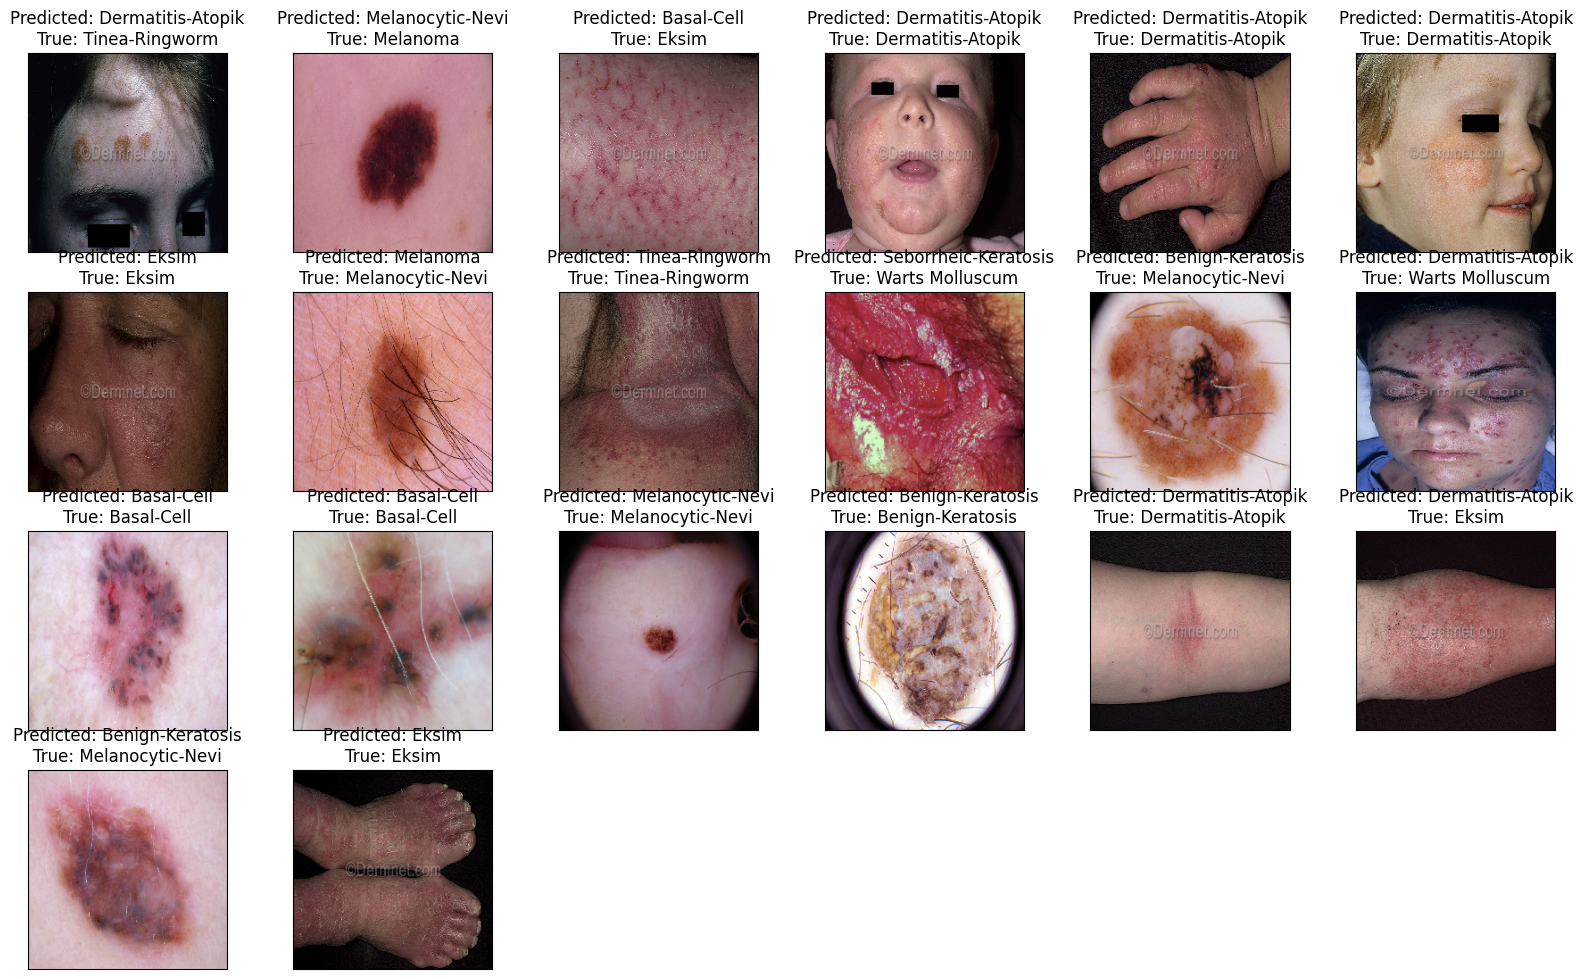

In [ ]:
# Get all images and labels from test_generator
test_generator.reset()
X_test, y_test = [], []
for _ in range(len(test_generator)):
    x, y = test_generator.next()
    X_test.extend(x)
    y_test.extend(y)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Predict classes for test set
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

# True classes for test set
true_classes = np.argmax(y_test, axis=1)

# Plot a random sample of test images, their predicted labels, and ground truth
# Number of samples to plot
num_samples = 20

# Get random sample of test indices
random_indices = np.random.choice(len(true_classes), size=num_samples, replace=False)

# Create figure
fig = plt.figure(figsize=(20, 15))  # Adjust the figure size to accommodate more images

for i, idx in enumerate(random_indices):
    ax = fig.add_subplot(5, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[idx])
    pred_label = class_labels[y_pred[idx]]
    true_label = class_labels[true_classes[idx]]
    ax.set_title(f"Predicted: {pred_label}\nTrue: {true_label}")

plt.show()